# Wholesale Customers (clientes mayoristas)

El objetivo de este proyecto es identificar y describir los distintos segmentos de clientes ocultos en los datos basandose en sus gastos anuales en diversas categorías de productos. Más información acerca de este dataset [aquí](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers).

Se comienza realizando una inspección del dataset.

In [2]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectWC/data/wholesale_customers_data.csv")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


Para entender qué significan las variables nominales, se ingresó al link del dataset en donde se encuentra la siguiente información:

CHANNEL: Horeca (Hotel/Restaurant/Café) or Retail channel

REGION: Lisnon, Oporto or Other

REGION Frequency: Lisbon: 77 - Oporto: 47 - Other Region: 316

CHANNEL Frequency: Horeca: 298 - Retail: 142

Para saber qué número corresponde a cada palabra calculo las frecuencias:

In [3]:
import numpy as np

print('Channel frequency:', np.sum(df['Channel']==1), np.sum(df['Channel']==2))
print('Region frequency:', np.sum(df['Region']==1), np.sum(df['Region']==2), np.sum(df['Region']==3))

Channel frequency: 298 142
Region frequency: 77 47 316


Para conocer la distribución de las variables grafico el pairplot del dataset:

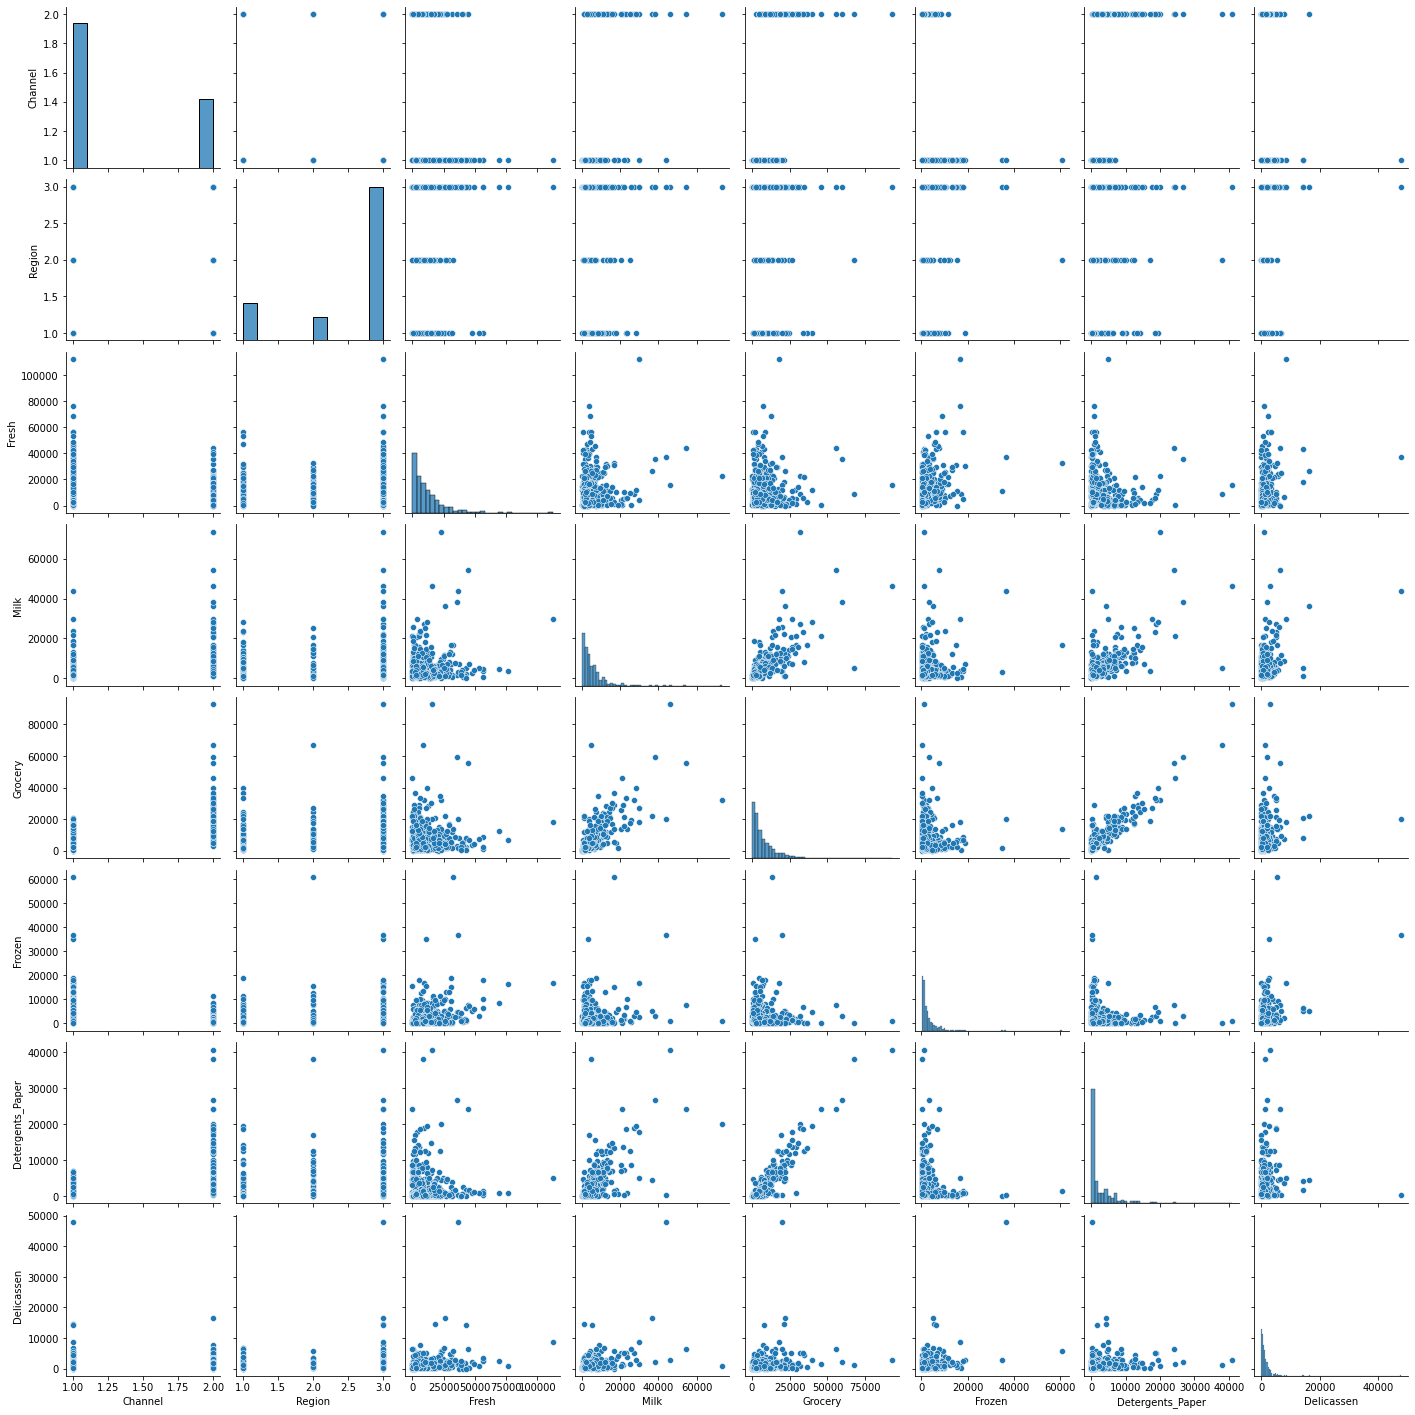

In [4]:
import seaborn as sns
sns.pairplot(df)

Como se puede ver, hay 2 variables nominales y 6 numéricas. Si se utilizan estas dos variables nominales en algoritmos de clustering basados en distancias en el espacio de atributos, podrían inducir separaciones indeseadas entre grupos. Esto es porque aunque se normalicen a media cero y varianza uno, la distancia entre los distintos valores que toman estas variables sigue siendo considerable. Por esto se decide no tenerlas en cuenta en un primer análisis.

# Determinación de la cantidad de segmentos de clientes

La cantidad de grupos o segmentos de clientes es en principio desconocida. Para determinarla se propone utilizar Mean-Shift, ya que resulta adecuado para encontrar las modas o puntos de máxima densidad local del espacio de atributos.

Comienzo normalizando los datos y descartando los atributos nominales.

In [27]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler()
X = s.fit_transform(df.drop(columns=['Channel', 'Region']).values)

Comienzo con los hiperparámetros por defecto:

In [6]:
from sklearn.cluster import MeanShift

ms = MeanShift()
ms.fit(X)

labels = np.unique(ms.labels_)
n_clusters_ = len(labels)

print('Número de clusters:', n_clusters_)

Número de clusters: 15


Del algoritmo surgieron 15 clusters, pero surge el interrogante de que este valor realmente represente a los datos. Una forma de averiguarlo podría ser analizando cómo varía este resultado al cambiar el parámetro principal del algoritmo, el cual es el "bandwidth". Por otro lado, interesa también conocer cómo es el tamaño de cada cluster.

Bandwidth por defecto: 1.86 

BW: 0.93 - N° de clusters: 52 - tamaños: [197  91  29  13  10  23   6   3   5  12   1   1   1   1   1   1   1   1
   1   1   1   1   1   4   1   1   1   2   1   1   1   1   1   1   1   1
   1   1   2   1   1   1   1   2   1   1   4   1   1   1   1   1]
BW: 1.03 - N° de clusters: 42 - tamaños: [283  26  12  17   3  10  12   2   3   8   1   1   1   1   1   1   1   1
   1   1   2   1  13   1   2   1   5   1   1   1   1   1   1   2   1   2
   1   1   1   1   1  13]
BW: 1.12 - N° de clusters: 37 - tamaños: [307  12  17   4  12   2   3  19   1   1   1   1   1   1   1   1   1   1
   2   1   1   8   1   3   1   1   1   1   1   9   1   2   1   1   5   1
  13]
BW: 1.22 - N° de clusters: 32 - tamaños: [328  16   3   5   4  11  19   1   1   7   1   1   1   1   1   1   1   3
   4   1   1   3   1   1   1   3   9   1   1   1   7   1]
BW: 1.31 - N° de clusters: 30 - tamaños: [342   3   6   5  20   1   1   7   1   1   1   1   1   1   1  10   5   1
   1   3   1   1   1   4 

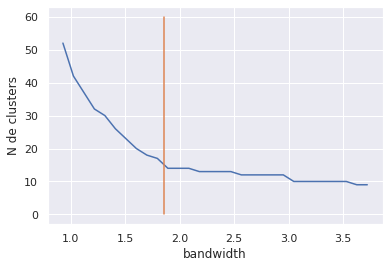

In [7]:
from sklearn.cluster import estimate_bandwidth
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Estimación del bandwidth por defecto que utiliza Mean-Shift
bw_def = estimate_bandwidth(X)
print('Bandwidth por defecto:', np.round(bw_def,3), '\n')

# Cantidad y tamaño de clusters para BWs entre el 50% y 200% del BW por defecto
bw_list = np.linspace(0.5*bw_def, 2*bw_def, num=30)
n_cluster_list = []
for bw in bw_list:
    ms = MeanShift(bandwidth=bw)
    ms.fit(X)
    n_clusters = len(np.unique(ms.labels_))
    n_cluster_list.append(n_clusters)
    print('BW:', np.round(bw,2), '- N° de clusters:', n_clusters, 
          '- tamaños:', np.bincount(ms.labels_))

# Grafico de cantidad de clusters vs bandwidth
sns.set_theme(style="darkgrid")
ax = sns.lineplot(data=pd.DataFrame({'bandwidth':bw_list, 
                                     'N de clusters':n_cluster_list}), 
                  x='bandwidth', y='N de clusters')
ax.plot([bw_def, bw_def], [0, 60])

En los tamaños de clusters se puede ver la mayoría de ellos contienen muy pocos elementos. Esto se debe a puntos aislados en donde el algoritmo converge porque no hay un gradiente de densidad alrededor de ellos. Estos puntos aislados o grupos pequeños pueden ser considerados outliers y no ser tenidos en cuenta, ya que lo que se quiere hacer es encontrar zonas de alta densidad que abarquen un número considerable de clientes.

Por otro lado, cuando bandwidth es mayor a 1.8 (o cuando la cantidad de grupos es menor a 15) más del 90% del dataset está concentrado en 1 cluster, lo cual indica que este valor es inadecuado.

A continuación se repite este análisis utilizando valores de bandwidth menores a 2 y descartando los grupos cuyo tamaño no sea representativo. Para esto último se define arbitrariamente que un cluster no es representativo cuando su tamaño es menor al 2% del dataset.

BW: 0.1 - N° de clusters: 0 - tamaños: []
BW: 0.15 - N° de clusters: 0 - tamaños: []
BW: 0.2 - N° de clusters: 2 - tamaños: [13 12]
BW: 0.25 - N° de clusters: 3 - tamaños: [16 14 11]
BW: 0.3 - N° de clusters: 7 - tamaños: [20 15 12 11 11 11 10]
BW: 0.35 - N° de clusters: 5 - tamaños: [30 28 26 12 11]
BW: 0.4 - N° de clusters: 6 - tamaños: [66 29 16 16 10 10]
BW: 0.45 - N° de clusters: 6 - tamaños: [78 36 17 13 10  9]
BW: 0.5 - N° de clusters: 8 - tamaños: [101  27  22  16  12  12  11  11]
BW: 0.55 - N° de clusters: 11 - tamaños: [110  28  19  18  14  13  12  11  10   9   9]
BW: 0.6 - N° de clusters: 8 - tamaños: [121  31  26  22  20  20  14  11]
BW: 0.65 - N° de clusters: 8 - tamaños: [142  35  34  24  24  19  10  10]
BW: 0.7 - N° de clusters: 7 - tamaños: [126  50  43  31  24  10   9]
BW: 0.75 - N° de clusters: 7 - tamaños: [148  56  38  30  22  14  13]
BW: 0.8 - N° de clusters: 6 - tamaños: [183  76  29  20  18  12]
BW: 0.85 - N° de clusters: 7 - tamaños: [226  48  24  20  19  12  11

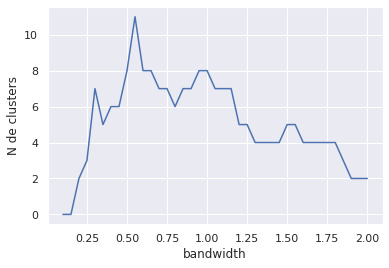

In [7]:
bw_list = np.linspace(0.1, 2, num=39)
n_cluster_list = []
n_clusters_clean_list = []
for bw in bw_list:
    ms = MeanShift(bandwidth=bw)
    ms.fit(X)
    n_clusters = len(np.unique(ms.labels_))
    n_cluster_list.append(n_clusters)

    # El vector outliers indica si el cluster correspondiente es outlier o no.
    # Se calcula cada tamaño de cluster y se lo compara con el mínimo valor.
    outliers = np.zeros((n_clusters,), dtype=np.bool_)
    labels_freq = np.bincount(ms.labels_)
    min_size = X.shape[0]*0.02
    for cluster_num in range(n_clusters):
        if labels_freq[cluster_num] < min_size:
            outliers[cluster_num] = True

    # Se calcula la cantidad y tamaño de clusters descartando los outliers
    n_clusters_clean = n_clusters - np.sum(outliers)
    n_clusters_clean_list.append(n_clusters_clean)
    labels_clean = labels_freq[outliers==False]
    labels_clean[::-1].sort()
    
    print('BW:', np.round(bw,2), '- N° de clusters:', n_clusters_clean, 
          '- tamaños:', labels_clean)

sns.set_theme(style="darkgrid")
ax = sns.lineplot(data=pd.DataFrame({'bandwidth':bw_list, 
                                     'N de clusters':n_clusters_clean_list}), 
                  x='bandwidth', y='N de clusters')

Interesa ahora analizar tres aspectos: Qué tan bien están separados los clusters remanentes (aquellos que no fueron considerados outliers), qué porcentaje del dataset fue considerado outlier y qué porcentaje del dataset representa el cluster más grande. Para lo primero, en scikit-learn se encontraron dos métricas que miden esto en datasets no etiquetados: la métrica de Calinski-Harabasz y la de Davies-Bouldin, donde los clusters están mejor separados cuanto mayor es la primer métrica y cuanto menor es la segunda. A continuación se analizan estos aspectos en función del bandwidth.

In [8]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

calinski_harabasz = []
davies_bouldin = []
clustered_percent = []
biggest_cluster_percent = []
bw_list = np.linspace(0.1, 2, num=39)
for bw in bw_list:
    ms = MeanShift(bandwidth=bw)
    ms.fit(X)
    n_clusters = len(np.unique(ms.labels_))

    outliers_bool = np.zeros((n_clusters,), dtype=np.bool_)
    labels_freq = np.bincount(ms.labels_)
    min_size = X.shape[0]*0.02
    for cluster_num in range(n_clusters):
        if labels_freq[cluster_num] < min_size:
            outliers_bool[cluster_num] = True

    outliers, = np.where(outliers_bool == True)
    element_wise_outliers = [np.any(outliers == label) for label in ms.labels_]

    X_clean = np.delete(X, element_wise_outliers, axis=0)
    labels_clean = ms.labels_[np.logical_not(element_wise_outliers)]

    if labels_clean.size == 0:
        calinski_harabasz.append(0)
        davies_bouldin.append(0)
        biggest_cluster_percent.append(0)
    else:
        calinski_harabasz.append(calinski_harabasz_score(X_clean, labels_clean))
        davies_bouldin.append(davies_bouldin_score(X_clean, labels_clean))
        biggest_cluster_percent.append(100*labels_freq.max()/X.shape[0])

    clustered_percent.append(100*X_clean.shape[0]/X.shape[0])
    

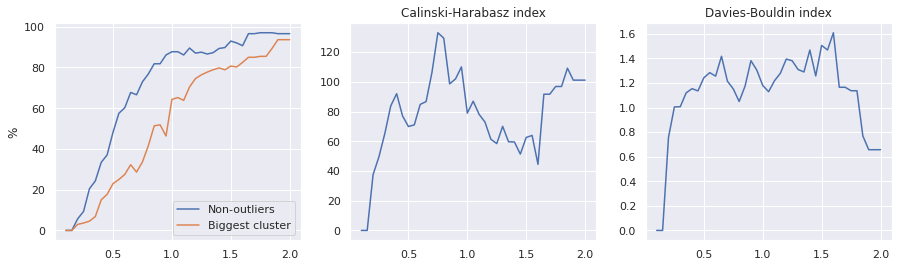

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
ax1.plot(bw_list, clustered_percent)
ax1.plot(bw_list, biggest_cluster_percent)
ax1.set_ylabel('%')
ax1.legend(['Non-outliers', 'Biggest cluster'])
ax2.title.set_text('Percentaje of the dataset')
ax2.plot(bw_list, calinski_harabasz)
ax2.title.set_text('Calinski-Harabasz index')
ax3.plot(bw_list, davies_bouldin)
ax3.title.set_text('Davies-Bouldin index')

En el primer gráfico (izq) se puede ver que para bandwidth<0.5 menos del 50% fue considerado como no-outlier, lo que quiere decir que más de la mitad del dataset fue considerado outlier. Esto se debe a que el bandwidth es demasiado chico y la mayoría de los clusters son considerados máximos locales, lo cual no es útil en este análisis. Por otro lado, para bandwidth>1.25 el mayor cluster representa al 80% del dataset, lo cual indica que este valor es demasiado grande y no permite ver distinguir entre las diferentes modas que se encuentran en ese 80% del dataset.

El índice de Calinski-Harabasz parece ir ascendiendo desde 0 a 0.75 y luego disminuyendo hasta 1.5. Luego de 1.5 asciende nuevamente, pero considerando lo mencionado anteriormente, esto podría deberse a que hay un único cluster que representa la mayoría del dataset.

El índice de Davies-Bouldin es considerablemente constante a lo largo de todo el rango, disminuyendo de manera notoria sólo para bandwidth>1.75. De nuevo, este rango mencionado ya está fuera del análisis. En 0.80 pareciera tener un mínimo local que coincide con la ubicación del máximo del indice de Calinski-Harabasz, aunque este mínimo está dentro de las variaciones del índice alrededor del valor medio.

Finalmente y volviendo al primer gráfico es interesante ver que la diferencia entre los porcentajes primero crece y luego decrece, mostrando una dependencia similar a la cantidad de clusters y al índice de Calinski-Harabasz. Esta diferencia representa el porcentaje de clusters que no fueron considerados como outliers y que tampoco forman parte del cluster de mayor tamaño. A continuación se muestra un gráfico de esta diferencia.

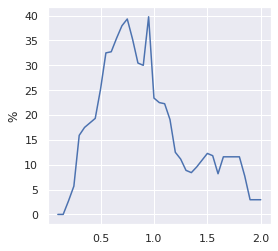

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(bw_list, np.array(clustered_percent) - np.array(biggest_cluster_percent))
ax.set_ylabel('%');

En este último gráfico se nota claramente la dependencia mencionada anteriormente y su correlación con la cantidad de clusters y el índice de Calinski-Harabasz. Considerando todos estos criterios, se puede concluir que el rango más adecuado de bandwidth está entre 0.65 y 1, de modo que la cantidad de clusters está entre 6 y 8. 

Otro método simple y muy utilizado para determinar la cantidad adecuada de clusters es utilizar K-Means y graficar para distintas cantidades de clusters la "inercia" o suma de cuadrados dentro de cada cluster. Este valor disminuye al aumentar la cantidad de clusters, pero lo hace decayendo de manera rápida para valores bajos y luego más lenta para valores altos. El punto de quiebre o "codo" donde se nota una distinción entre las diferentes velocidades de caída de este valor es generalmente una buena elección de K. 

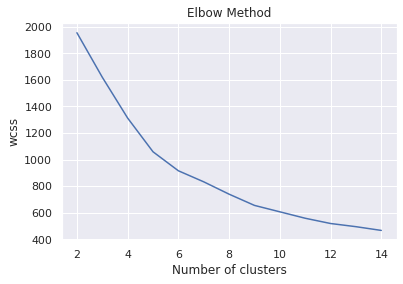

In [9]:
from sklearn.cluster import KMeans
wcss = []
for i in range(2,15):
    km=KMeans(n_clusters=i, init='k-means++', random_state=0)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(2,15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

En el gráfico anterior se distingue un "codo" entre 5 y 6. Considerando que para el método anterior el mejor candidato parecía ser con bandwidth=0.8 que corresponde a un número de clusters igual a 6, se elige este valor como cantidad de segmentos de clientes.

# Selección del algoritmo a utilizar para la segmentación

Se comienza comparando los centroides estimados por los dos algoritmos utilizados hasta el momento.

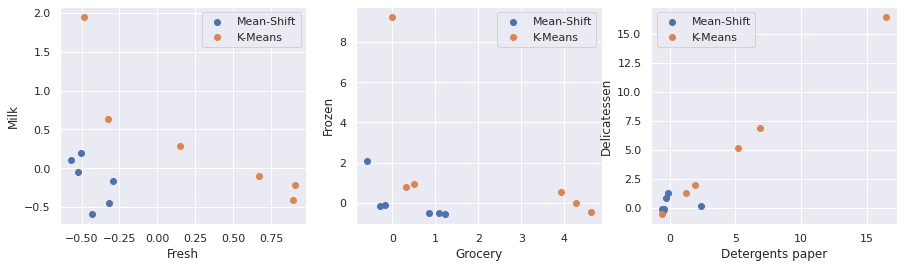

In [12]:
ms = MeanShift(bandwidth=0.8)
ms.fit(X)

n_clusters = len(np.unique(ms.labels_))
outliers = np.zeros((n_clusters,), dtype=np.bool_)
labels_freq = np.bincount(ms.labels_)
min_size = X.shape[0]*0.02
for cluster_num in range(n_clusters):
    if labels_freq[cluster_num] < min_size:
        outliers[cluster_num] = True
ms_cluster_centers_ = ms.cluster_centers_[outliers==False]

km = KMeans(n_clusters=6, init='k-means++', random_state=0)
km.fit(X)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
ax1.scatter(ms_cluster_centers_[0,:], ms_cluster_centers_[1,:])
ax1.scatter(km.cluster_centers_[0,:], km.cluster_centers_[1,:])
ax1.set_xlabel('Fresh')
ax1.set_ylabel('Milk')
ax1.legend(['Mean-Shift', 'K-Means'])
ax2.scatter(ms_cluster_centers_[2,:], ms_cluster_centers_[3,:])
ax2.scatter(km.cluster_centers_[2,:], km.cluster_centers_[3,:])
ax2.set_xlabel('Grocery')
ax2.set_ylabel('Frozen')
ax2.legend(['Mean-Shift', 'K-Means'])
ax3.scatter(ms_cluster_centers_[4,:], ms_cluster_centers_[5,:])
ax3.scatter(km.cluster_centers_[5,:], km.cluster_centers_[5,:])
ax3.set_xlabel('Detergents paper')
ax3.set_ylabel('Delicatessen')
ax3.legend(['Mean-Shift', 'K-Means'])

Como se puede ver, si bien las estimaciones de cantidad de grupos con ambos algoritmos fue similar, los centroides que éstos estiman son muy diferentes. Algo que podría estar pasando es que el ~20% que fue considerado outlier en el Mean-Shift esté sesgando los centroides en el K-Means. Se repite esta prueba entonces eliminando los outliers también para el K-Means.

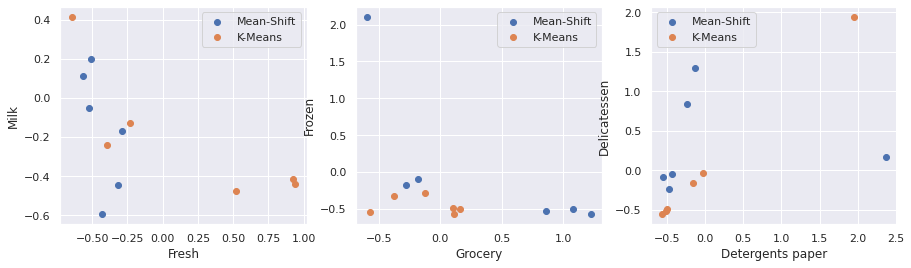

In [13]:
ms = MeanShift(bandwidth=0.8)
ms.fit(X)

n_clusters = len(np.unique(ms.labels_))
outliers = np.zeros((n_clusters,), dtype=np.bool_)
labels_freq = np.bincount(ms.labels_)
min_size = X.shape[0]*0.02
for cluster_num in range(n_clusters):
    if labels_freq[cluster_num] < min_size:
        outliers[cluster_num] = True
ms_cluster_centers_ = ms.cluster_centers_[outliers==False]

outliers_labels, = np.where(outliers == True)
element_wise_outliers = [np.any(outliers_labels == label) for label in ms.labels_]
X_clean = np.delete(X, element_wise_outliers, axis=0)

km = KMeans(n_clusters=6, init='k-means++', random_state=0)
km.fit(X_clean)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
ax1.scatter(ms_cluster_centers_[0,:], ms_cluster_centers_[1,:])
ax1.scatter(km.cluster_centers_[0,:], km.cluster_centers_[1,:])
ax1.set_xlabel('Fresh')
ax1.set_ylabel('Milk')
ax1.legend(['Mean-Shift', 'K-Means'])
ax2.scatter(ms_cluster_centers_[2,:], ms_cluster_centers_[3,:])
ax2.scatter(km.cluster_centers_[2,:], km.cluster_centers_[3,:])
ax2.set_xlabel('Grocery')
ax2.set_ylabel('Frozen')
ax2.legend(['Mean-Shift', 'K-Means'])
ax3.scatter(ms_cluster_centers_[4,:], ms_cluster_centers_[5,:])
ax3.scatter(km.cluster_centers_[5,:], km.cluster_centers_[5,:])
ax3.set_xlabel('Detergents paper')
ax3.set_ylabel('Delicatessen')
ax3.legend(['Mean-Shift', 'K-Means'])

Si bien ahora los centroides están más cercanos, la distribución es muy diferente. Interesa entonces visualizar cómo son los agrupamientos realizados por ambos. En el caso del K-Means interesa analizar los dos casos: considerando los outliers y sin considerarlos. Para el caso de Mean-Shift, todos los outliers serán considerados un único cluster.

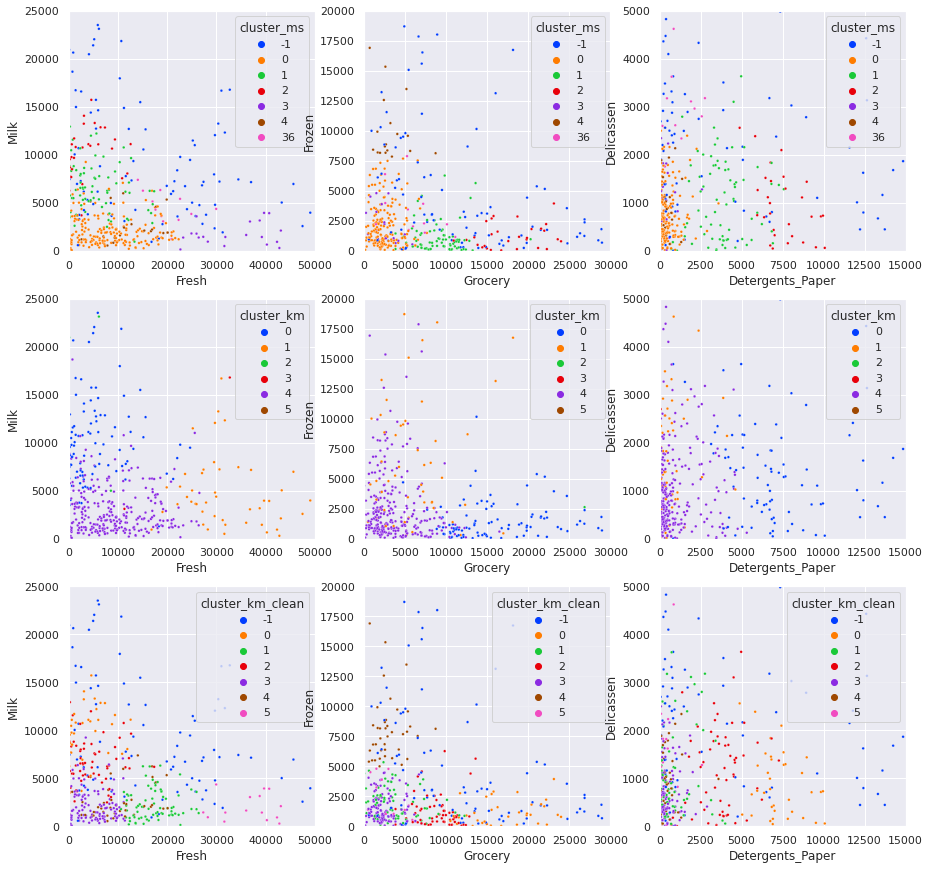

In [10]:
ms = MeanShift(bandwidth=0.8)
ms.fit(X)

n_clusters = len(np.unique(ms.labels_))
outliers = np.zeros((n_clusters,), dtype=np.bool_)
labels_freq = np.bincount(ms.labels_)
min_size = X.shape[0]*0.02
for cluster_num in range(n_clusters):
    if labels_freq[cluster_num] < min_size:
        outliers[cluster_num] = True

outliers_labels, = np.where(outliers == True)
labels_ms = []
for label in ms.labels_:
    if np.any(outliers_labels == label):
        labels_ms.append(-1)
    else:
        labels_ms.append(label)

element_wise_outliers = [np.any(outliers_labels == label) for label in ms.labels_]
X_clean = np.delete(X, element_wise_outliers, axis=0)

km = KMeans(n_clusters=6, init='k-means++', random_state=0)
km.fit(X)
labels_km = km.labels_

km_clean = KMeans(n_clusters=6, init='k-means++', random_state=0)
km_clean.fit(X_clean)
labels_km_clean = []
idx = 0
for x in element_wise_outliers:
    if x:
        labels_km_clean.append(-1)
    else:
        labels_km_clean.append(km_clean.labels_[idx])
        idx += 1

df2 = pd.concat([df, pd.DataFrame({'cluster_ms':labels_ms, 
                                  'cluster_km':labels_km,
                                  'cluster_km_clean':labels_km_clean})], axis=1)

marker_size = 7
fig, axes = plt.subplots(3, 3, figsize=(15,15))

# Primera fila: Mean-Shift
sns.scatterplot(ax=axes[0,0], data=df2, x='Fresh', y='Milk', hue='cluster_ms', palette='bright', s=marker_size)
sns.scatterplot(ax=axes[0,1], data=df2, x='Grocery', y='Frozen', hue='cluster_ms', palette='bright', s=marker_size)
sns.scatterplot(ax=axes[0,2], data=df2, x='Detergents_Paper', y='Delicassen', hue='cluster_ms', palette='bright', s=marker_size)

# Segunda fila: K-Means (todo el dataset)
sns.scatterplot(ax=axes[1,0], data=df2, x='Fresh', y='Milk', hue='cluster_km', palette='bright', s=marker_size)
sns.scatterplot(ax=axes[1,1], data=df2, x='Grocery', y='Frozen', hue='cluster_km', palette='bright', s=marker_size)
sns.scatterplot(ax=axes[1,2], data=df2, x='Detergents_Paper', y='Delicassen', hue='cluster_km', palette='bright', s=marker_size)

# Tercera fila: K-Means (sin outliers)
sns.scatterplot(ax=axes[2,0], data=df2, x='Fresh', y='Milk', hue='cluster_km_clean', palette='bright', s=marker_size)
sns.scatterplot(ax=axes[2,1], data=df2, x='Grocery', y='Frozen', hue='cluster_km_clean', palette='bright', s=marker_size)
sns.scatterplot(ax=axes[2,2], data=df2, x='Detergents_Paper', y='Delicassen', hue='cluster_km_clean', palette='bright', s=marker_size)
for i in range(axes.shape[0]):
    axes[i,0].set_ylim(0,25000)
    axes[i,0].set_xlim(0,50000)
    axes[i,1].set_ylim(0,20000)
    axes[i,1].set_xlim(0,30000)
    axes[i,2].set_ylim(0,5000)
    axes[i,2].set_xlim(0,15000)


Analizando los gráficos se concluyó que los dos modelos que mejor separan a los datos son el Mean-Shift y el K-Means sin outliers. El K-Means utilizando el dataset entero separa relativamente bien a los datos, pero la gran mayoría del dataset corresponde a tres clusters. Para verificar esto se calculan los tamaños de clusters resultantes de este modelo:

In [11]:
for label in np.unique(labels_km):
    print(np.sum(labels_km==label))

98
53
10
2
276
1


Efectivamente, dos de los clusters son demasiado pequeños. En general y a simple vista, Mean-Shift parece ofrecer los mejores resultados. Por otro lado, si bien los outliers son todos puntos que están dispersos y alejados del origen, algunos de ellos parecieran estar a poca distancia de algunos clusters e incluso mezclados con ellos. Por esto, lo ideal sería utilizar los centroides generados por Mean-Shift pero incluyendo los outliers, lo cual se implementa a continuación.

(0.0, 20000.0)

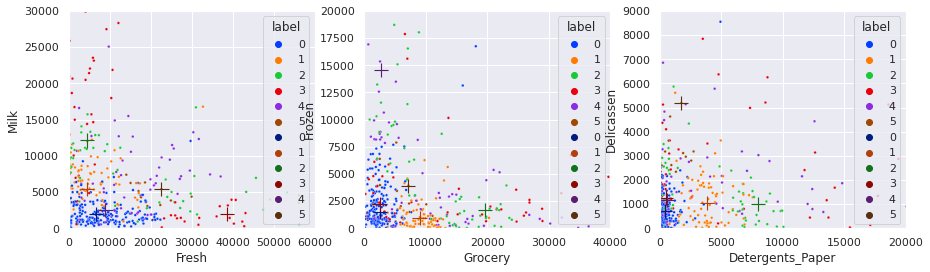

In [41]:
centers_ms = ms.cluster_centers_[outliers == False]
cluster_labels = np.arange(len(ms.cluster_centers_))
outliers_idx, = np.where(outliers == True)
cluster_labels = np.delete(cluster_labels, outliers_idx)
for (idx,), its_outlier in np.ndenumerate(element_wise_outliers):
    if its_outlier:
        distances = []
        for center in centers_ms:
            distances.append(np.linalg.norm(X[idx]-center))
        labels_ms[idx] = cluster_labels[np.argmax(distances)]

# Cambio el número de cluster 36 a 5 para tener valores del 0 al 5
labels_ms = np.array(labels_ms)
labels_ms[labels_ms == 36] = 5

df3 = pd.concat([df, pd.DataFrame({'label':labels_ms})], axis=1)
df_centers = pd.DataFrame(s.inverse_transform(centers_ms), columns=df.drop(columns=['Region','Channel']).columns)
df_centers = pd.concat([df_centers, pd.DataFrame({'label':np.arange(df_centers.shape[0])})], axis=1)

marker_size = 7
fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.scatterplot(ax=axes[0], data=df3, x='Fresh', y='Milk', hue='label', palette='bright', s=marker_size)
sns.scatterplot(ax=axes[0], data=df_centers, x='Fresh', y='Milk', hue='label', palette='dark', s=200, marker='+')
sns.scatterplot(ax=axes[1], data=df3, x='Grocery', y='Frozen', hue='label', palette='bright', s=marker_size)
sns.scatterplot(ax=axes[1], data=df_centers, x='Grocery', y='Frozen', hue='label', palette='dark', s=200, marker='+')
sns.scatterplot(ax=axes[2], data=df3, x='Detergents_Paper', y='Delicassen', hue='label', palette='bright', s=marker_size)
sns.scatterplot(ax=axes[2], data=df_centers, x='Detergents_Paper', y='Delicassen', hue='label', palette='dark', s=200, marker='+')
axes[0].set_ylim(0,30000)
axes[0].set_xlim(0,60000)
axes[1].set_ylim(0,20000)
axes[1].set_xlim(0,40000)
axes[2].set_ylim(0,9000)
axes[2].set_xlim(0,20000)

Y los nuevos tamaños de clusters son:

In [17]:
for label in np.unique(labels_ms):
    print(np.sum(labels_ms==label))

187
77
54
50
60
12


# Descripción de los segmentos de clientes

Se comienza realizando un gráfico de barras que muestra el gasto promedio de los integrantes de cada grupo en cada una de las categorías de productos. Las líneas negras marcan el intervalo de confianza del 95% de la media.

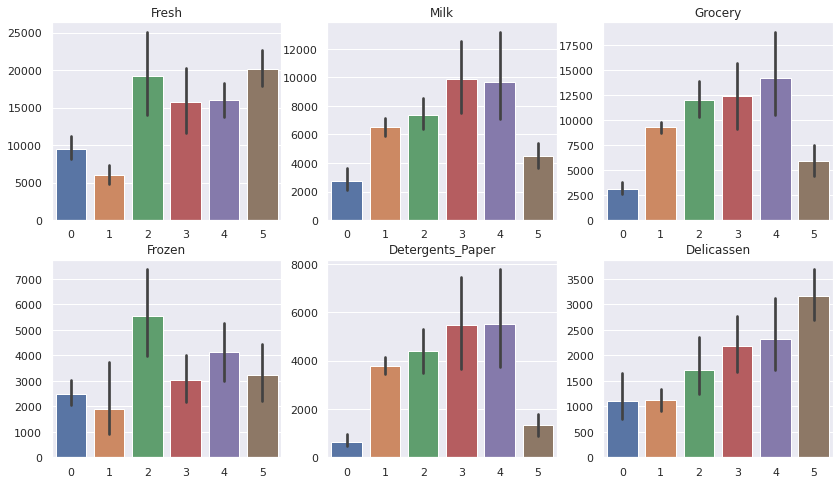

In [138]:
fig, axes = plt.subplots(2, 3, figsize=(14,8))
for r,c in np.ndindex((2,3)):
    sns.barplot(ax=axes[r,c], x='label', y=df3.columns[3*r+c+2], data=df3, 
                ci=95, estimator=np.mean)
    axes[r,c].set_title(df3.columns[3*r+c+2])
    axes[r,c].set_ylabel('')    
    axes[r,c].set_xlabel('')

En este gráfico de barras se puede llegar a conclusiones como que el grupo 0 (azul) gasta más en "Fresh" y "Frozen" que en "Detergents paper" (de manera relativa al resto de los grupos), o que el consumo del grupo 1 (naranja) en "Frozen" es muy variado.

Por otro lado, interesa conocer la distribución de las variables nominales que no fueron tenidas en cuenta en el clustering. A continuación se muestran gráficos de torta que indican la proporción de consumo que fue realizado en los canales "Hotel/Restaurant/Café" o en "Retail" por cada grupo.

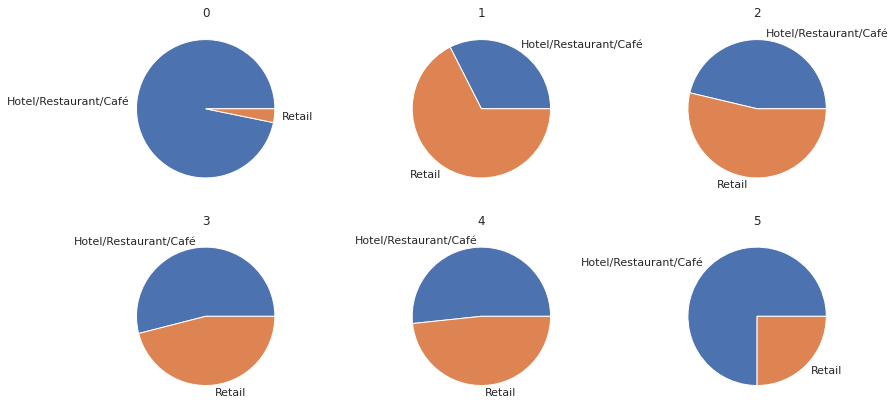

In [135]:
fig, axes = plt.subplots(2, 3, figsize=(14,7))
for r,c in np.ndindex((2,3)):
    axes[r,c].set_title(str(3*r+c))
    axes[r,c].pie(np.bincount(df3.iloc[df3.values[:,-1]==3*r+c, 0].values)[1:3],
                  labels=['Hotel/Restaurant/Café', 'Retail'])

A continuación se muestra el mismo gráfico pero para el atributo "Region".

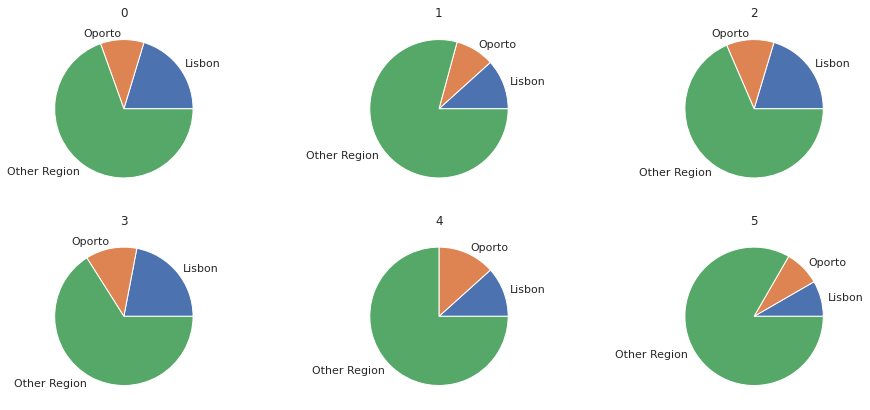

In [129]:
fig, axes = plt.subplots(2, 3, figsize=(16,7))
for r,c in np.ndindex((2,3)):
    axes[r,c].set_title(str(3*r+c))
    axes[r,c].pie(np.bincount(df3.iloc[df3.values[:,-1]==3*r+c, 1].values)[1:4],
                  labels=['Lisbon', 'Oporto', 'Other Region'])

Finalmente, podría ser útil saber para cada categoría cuánto porcentaje representa cada grupo. 

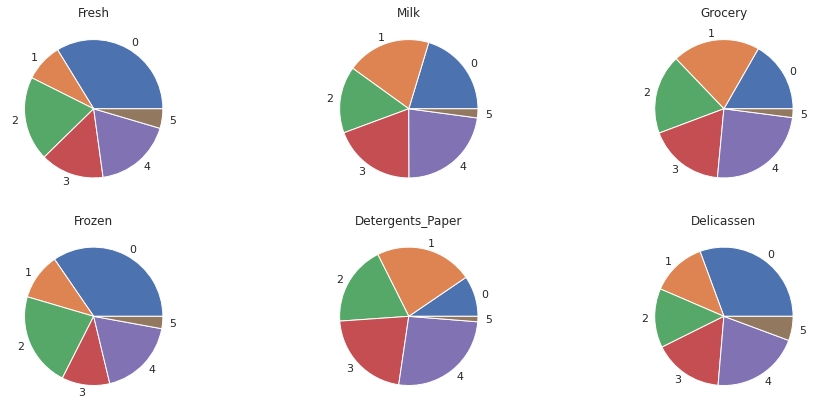

In [130]:
fig, axes = plt.subplots(2, 3, figsize=(16,7))
for r,c in np.ndindex((2,3)):
    spend = [np.sum(df3.iloc[df3.values[:,-1]==label, 2+3*r+c]) for label in range(6)]
    axes[r,c].set_title(df3.columns[2+3*r+c])
    axes[r,c].pie(spend, labels=[str(x) for x in range(6)])

La información que proporciona este último gráfico se complementa con el primero. Por ejemplo, los integrantes del grupo 5 (marrón) son los que más gastan en promedio en "Delicassen", pero el grupo 5 en su conjunto es el menos representativo de esta categoría. Esto se debe a que el grupo 5 es muy reducido en tamaño en comparación con el resto.

# Conclusión

El clustering resulta útil para este tipo de aplicaciones, ayudando a extraer patrones de comportamiento de los clientes que luego pueden ser utilizados para incrementar las ventas o mejorar la logística o servicios que provee el vendedor.

Se utilizaron distintas técnicas para encontrar la cantidad adecuada de segmentos y quedaron otras más por explorar. Por ejemplo, un enfoque que parece prometedor podría ser utilizar el algoritmo OPTICS, tanto para obtener la cantidad de grupos como para hacer el agrupamiento. Con las técnicas utilizadas se obtuvo un rango de entre 5 y 8 grupos, eligiéndose un valor de 6. Otro enfoque podría haber sido elegir 8 y si al final surgían dos o más grupos similares entre sí se podían considerar como uno solo. 

Se encontraron además diferentes decisiones que debieron tomarse, como por ejemplo si incluir o no los outliers dentro de los clusters más cercanos, o si considerar o no las variables nominales al realizar el clustering.